#libraries

In [1]:
import os
import cv2
import numpy as np
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from zipfile import ZipFile
ZipFile('/content/drive/MyDrive/Shop DataSet.zip', 'r').extractall('/content')

#Data



In [4]:
# Function to extract frames from video
def extract_frames(video_path, frame_rate=1):
    vidcap = cv2.VideoCapture(video_path)
    frames = []
    success, image = vidcap.read()
    count = 0
    while success:
        if count % frame_rate == 0:
            frames.append(image)
        success, image = vidcap.read()
        count += 1
    vidcap.release()
    return frames

# Function to resize frames
def resize_frames(frames, target_size=(128, 128)):
    return [cv2.resize(frame, target_size) for frame in frames]

# Function to normalize frames
def normalize_frames(frames):
    return [frame / 255.0 for frame in frames]

# Function to pad/truncate frames to a fixed number of frames
def pad_frames(frames, max_length=15, frame_size=(128, 128, 3)):
    if len(frames) < max_length:
        # Padding with black frames
        padding = [np.zeros(frame_size) for _ in range(max_length - len(frames))]
        frames.extend(padding)
    else:
        # Trim longer videos
        frames = frames[:max_length]
    return frames

# Function to prepare data
def prepare_data(root_dir, max_frames=15, target_size=(128, 128)):
    data = []
    labels = []

    # Iterate through both classes (folders)
    for label, folder in enumerate(['non shop lifters', 'shop lifters']):
        folder_path = os.path.join(root_dir, folder)

        # Read all videos in the folder
        for video_name in os.listdir(folder_path):
            video_path = os.path.join(folder_path, video_name)

            # Extract frames from video
            frames = extract_frames(video_path)

            # Resize and normalize frames
            frames = resize_frames(frames, target_size)
            frames = normalize_frames(frames)

            # Pad/truncate frames to a fixed length
            frames = pad_frames(frames, max_length=max_frames, frame_size=(*target_size, 3))

            # Add to dataset
            data.append(frames)
            labels.append(label)

    # Convert to NumPy arrays
    data = np.array(data)
    labels = np.array(labels)

    # Optionally, convert labels to categorical if required for training
    labels = to_categorical(labels, num_classes=2)

    return data, labels

# Example usage
root_dir = '/content/Shop DataSet'
data, labels = prepare_data(root_dir)

# Check data shape
print("Data shape:", data.shape)  # Should be (num_videos, max_frames, height, width, channels)
print("Labels shape:", labels.shape)  # Should be (num_videos, 2)


Data shape: (855, 15, 128, 128, 3)
Labels shape: (855, 2)


#Visualization

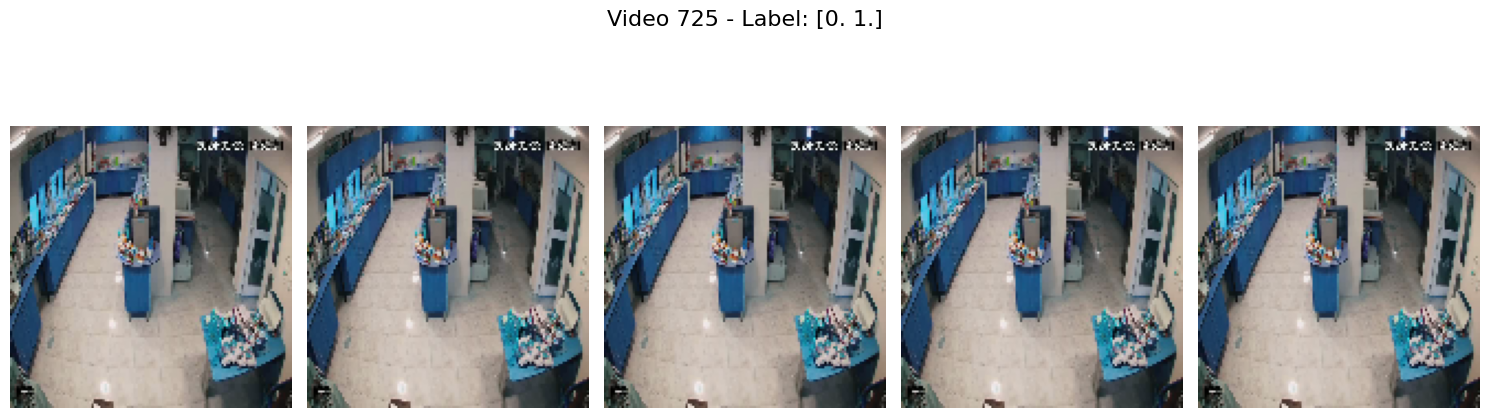

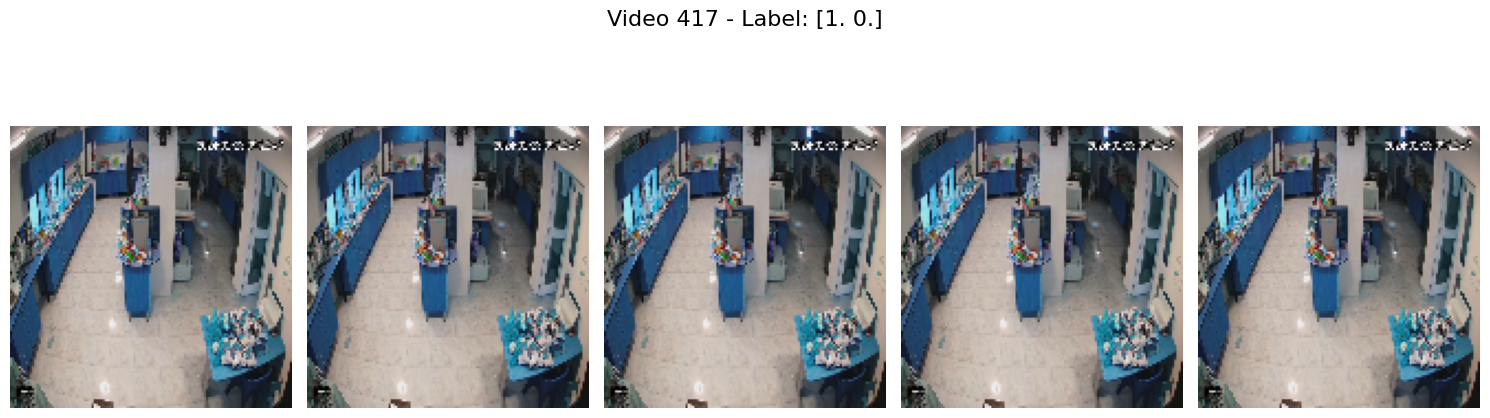

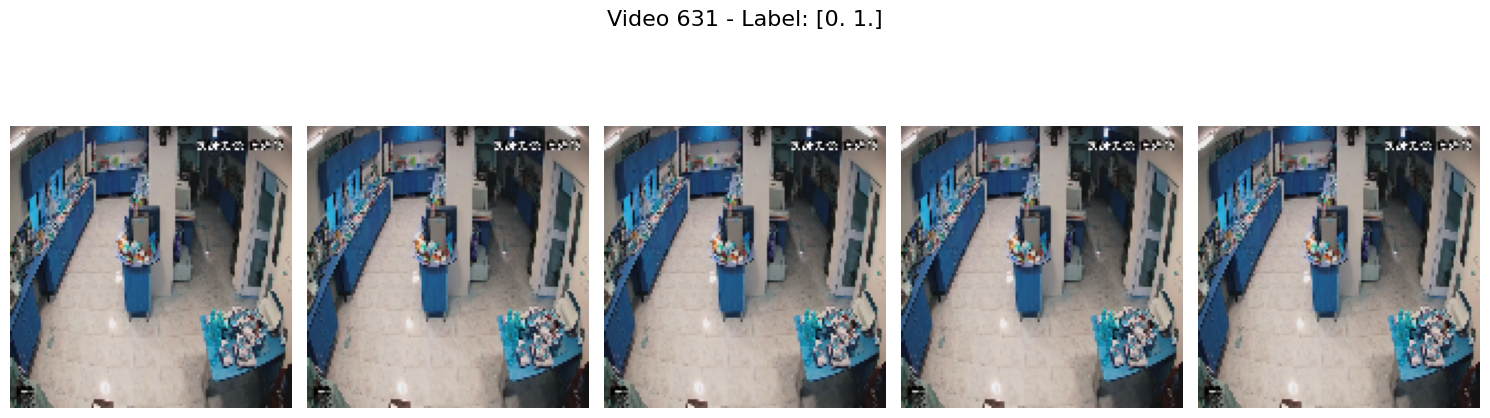

In [5]:
def show_sample_frames(data, labels, num_videos=3, num_frames=5):
    """
    Display frames from random videos in the dataset.

    Args:
    - data (list): List of preprocessed frames for each video.
    - labels (list): List of corresponding labels for each video.
    - num_videos (int): Number of random videos to display.
    - num_frames (int): Number of frames to display per video.
    """
    # Select a few random indices to display
    indices = np.random.choice(len(data), size=num_videos, replace=False)

    for i, idx in enumerate(indices):
        video_frames = data[idx]
        video_label = labels[idx]

        plt.figure(figsize=(15, 5))
        plt.suptitle(f'Video {idx} - Label: {video_label}', fontsize=16)

        for j in range(min(num_frames, len(video_frames))):
            plt.subplot(1, num_frames, j + 1)
            plt.imshow(video_frames[j])
            plt.axis('off')

        plt.tight_layout()
        plt.show()
show_sample_frames(data, labels, num_videos=3, num_frames=5)


#Model

In [6]:
train_videos, test_videos, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define the CNN-LSTM model
def create_model(input_shape=(15, 128, 128, 3)):
    model = models.Sequential()

    # CNN layers (TimeDistributed)
    model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
    model.add(layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu')))
    model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))

    # Flatten CNN output before feeding to LSTM/GRU
    model.add(layers.TimeDistributed(layers.Flatten()))

    # LSTM layers for temporal sequence processing (can switch to GRU)
    model.add(layers.LSTM(128, return_sequences=False))  # or use GRU(128)

    # Fully connected layers
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))  # 2 classes: shoplifter and non-shoplifter

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model = create_model()

# Print model summary
model.summary()

# Train the model
history = model.fit(
    train_videos,
    train_labels,
    validation_split=0.2,  # 20% of the training data used for validation
    epochs=10,             # Increase epochs based on your needs
    batch_size=16,         # Adjust based on available memory
    verbose=1
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_videos, test_labels)
print(f'Test accuracy: {test_acc}')

# Optionally, save the trained model
model.save('cnn_lstm_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 15, 126, 126, 32   896       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 15, 63, 63, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 15, 61, 61, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 15, 30, 30, 64)    0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 15, 28, 28, 128)   7

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
